# Assignment 4

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

from milligrad import Tensor
import numpy as np

np.random.seed(1337)

### 0.1 - Read in the data

In [2]:
# Read in data
with open('goblet_book.txt', 'r') as f:
    book_data = f.read()

# Create mappings
BOS, BOS_ID = "<BOS>", 0
# EOS, EOS_ID = "<EOS>", 1

chr_to_ids = {BOS: BOS_ID}
for c in sorted(set(book_data)): chr_to_ids[c] = len(chr_to_ids)
# chr_to_ids = {c: i for i, c in enumerate(sorted(set(book_data)))}
ids_to_chr = {i: c for c, i in chr_to_ids.items()}

def tokenize(text:str)->list[int]: # cannot tokenize generated text (i.e. those containing <BOS>)
    return [chr_to_ids[c] for c in text]

def detokenize(tokens:list[int])->str:
    return "".join([ids_to_chr[ids] for ids in tokens])

### 0.2 - Hyperparameters

In [3]:
INPUT_DIM = len(chr_to_ids)
HIDDEN_DIM = 100
BATCH_SIZE = 64
SEQ_LEN = 25
ETA = 0.1

### 0.3 and 0.4 - Initialize RNN and implement forward pass (backward pass handled by the autograd)

In [4]:
class RNN:
    def __init__(self, input_dim:int, hidden_dim:int):
        self.input_dim, self.hidden_dim = input_dim, hidden_dim
        self.wi = Tensor.xavier(input_dim, hidden_dim)
        self.wh = Tensor.xavier(hidden_dim, hidden_dim)
        self.bh = Tensor.zeros(hidden_dim)

        self.wo = Tensor.xavier(hidden_dim, input_dim)
        self.bo = Tensor.zeros(input_dim)

    def __call__(self, x:Tensor, h:Tensor=None)->Tensor:
        B, L, _ = x.shape

        if h is None: h = Tensor.zeros(B, self.hidden_dim)

        outputs = []
        for i in range(L):
            h = (x[:,i,:] @ self.wi + h @ self.wh + self.bh).tanh()
            outputs.append(h)

        stacked_outputs = Tensor.stack(outputs, axis=1)
        return stacked_outputs @ self.wo + self.bo, h
    
    def parameters(self)->list[Tensor]:
        return [self.wi, self.wh, self.bh, self.wo, self.bo]
    
model = RNN(INPUT_DIM, HIDDEN_DIM)
out, h = model(Tensor.randn(32, 4, INPUT_DIM)) # smaller seq to view the backpropagation graph
out.shape

(32, 4, 81)

### 0.5 - Verify gradients

I will assume that my architecture is correct and simply verify the gradient calculations by comparing to a pytorch implementation with the same weights.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TorchRNN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int):
        super(TorchRNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.wi = nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(input_dim, hidden_dim)))
        self.wh = nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(hidden_dim, hidden_dim)))
        self.bh = nn.Parameter(torch.zeros(hidden_dim))

        self.wo = nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(hidden_dim, input_dim)))
        self.bo = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x, h=None):
        B, L, _ = x.shape

        if h is None:
            h = torch.zeros(B, self.hidden_dim)

        outputs = []
        for i in range(L):
            h = torch.tanh(x[:, i,:] @ self.wi + h @ self.wh + self.bh)
            outputs.append(h)

        stacked_outputs = torch.stack(outputs, dim=1)
        return stacked_outputs @ self.wo + self.bo, h

    def copy_weights_from(self, original_rnn):
        with torch.no_grad():
            self.wi.copy_(torch.from_numpy(original_rnn.wi.data).clone().detach())
            self.wh.copy_(torch.from_numpy(original_rnn.wh.data).clone().detach())
            self.bh.copy_(torch.from_numpy(original_rnn.bh.data).clone().detach())
            self.wo.copy_(torch.from_numpy(original_rnn.wo.data).clone().detach())
            self.bo.copy_(torch.from_numpy(original_rnn.bo.data).clone().detach())


In [6]:
milli_model = RNN(INPUT_DIM, HIDDEN_DIM)
torch_model = TorchRNN(INPUT_DIM, HIDDEN_DIM)
torch_model.copy_weights_from(milli_model)

x_np = np.random.randn(BATCH_SIZE, SEQ_LEN, INPUT_DIM).astype(np.float32)
h_np = np.random.randn(BATCH_SIZE, HIDDEN_DIM).astype(np.float32)

milli_out, _ = milli_model(Tensor(x_np), Tensor(h_np))
torch_out, _ = torch_model(torch.from_numpy(x_np), torch.from_numpy(h_np))

np.testing.assert_allclose(
    milli_out.data, torch_out.detach().numpy(),
    atol=1e-5
)

milli_out.sum().backward()
torch_out.sum().backward()

np.testing.assert_allclose(
    milli_model.wi.grad, torch_model.wi.grad.detach().numpy(),
    atol=3e-4
)

### 0.6 - Gradient clipping

In [7]:
def clip_gradient(parameters:list[Tensor]):
    for p in parameters:
        p.grad = np.clip(p.grad, -5, 5)


### 0.7 - Implement AdaGrad optimizer

In [8]:
class AdaGrad:
    def __init__(self, params:list[Tensor], lr:float=0.01, epsilon:float=1e-8):
        self.params = params
        self.lr = lr
        self.epsilon = epsilon
        self.cache = [np.zeros_like(p.data) for p in self.params]

    def step(self):
        for i, p in enumerate(self.params):
            self.cache[i] += p.grad ** 2
            p.data -= self.lr * p.grad / (np.sqrt(self.cache[i]) + self.epsilon)

    def zero_grad(self):
        for p in self.params: p.grad = np.zeros_like(p.grad)
               

### 0.8 - Implement text synthesis

In [9]:
def generate_deterministic(model, max_length=1000)->str:
    h = Tensor.zeros(1, HIDDEN_DIM) # batch size is 1
    tokens = [BOS_ID]
    for _ in range(max_length):
        ohe = np.eye(len(chr_to_ids))[tokens[-1]]
        x = Tensor(ohe.reshape(1,1,-1)) # batch size 1, "seq_len" 1
        out, h = model(x, h)
        token = out.data.squeeze().argmax()

        tokens.append(token)

    return detokenize(tokens[1:])

def generate_nondeterministic(model, max_length=1000, temperature:float=1.0)->str:
    h = Tensor.zeros(1, HIDDEN_DIM) # batch size is 1
    tokens = [BOS_ID]
    for _ in range(max_length):
        ohe = np.eye(len(chr_to_ids))[tokens[-1]]
        x = Tensor(ohe.reshape(1,1,-1)) # batch size 1, "seq_len" 1
        out, h = model(x, h)
        p = (out / temperature).softmax()
        token = np.random.choice(range(len(chr_to_ids)), p=p.data.flatten())

        tokens.append(token)

    return detokenize(tokens[1:])

def generate_nondeterministic_nucleous(model, max_length=1000, temperature:float=1.0, nucleus_threshold:float=0.9)->str:
    h = Tensor.zeros(1, HIDDEN_DIM)  # batch size is 1
    tokens = [BOS_ID]
    
    for _ in range(max_length):
        ohe = np.eye(len(chr_to_ids))[tokens[-1]]
        x = Tensor(ohe.reshape(1, 1, -1))  # batch size 1, "seq_len" 1
        out, h = model(x, h)
        p = (out / temperature).softmax()
        p_data = p.data.flatten()

        # Nucleus sampling
        sorted_indices = np.argsort(p_data)[::-1]
        cumulative_probs = np.cumsum(p_data[sorted_indices])
        cutoff = np.searchsorted(cumulative_probs, nucleus_threshold)
        top_indices = sorted_indices[:cutoff + 1]
        
        p_top = p_data[top_indices]
        p_top /= p_top.sum()  # Normalize to form a probability distribution
        
        token = np.random.choice(top_indices, p=p_top)
        tokens.append(token)
    
    return detokenize(tokens[1:])
        
generate_deterministic(model, 10), generate_nondeterministic(model, 10, 0.5), generate_nondeterministic_nucleous(model, 10, 0.5, 0.9)

('eEgTlz7ioD', 'Bhvü9q•yC2', 'JQ?IqM/40A')

### 0.9 - Implement training loop

In [10]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate split indices
data_size = len(book_data)
train_size = int(data_size * train_ratio)
val_size = int(data_size * val_ratio)

# Split the book_data
train_data = book_data[:train_size]
val_data = book_data[train_size:train_size + val_size]
test_data = book_data[train_size + val_size:]

In [11]:
            
def dataloader(data, batch_size, seq_length, shuffle=False):
    data_size = len(data)
    num_batches = data_size // (seq_length * batch_size)
    
    ohe_matrix = np.eye(len(chr_to_ids))

    trimmed_data = data[:num_batches * seq_length * batch_size]
    ohe_data = ohe_matrix[tokenize(trimmed_data)]

    BOS_OHE = ohe_matrix[[BOS_ID] * batch_size].reshape(batch_size, 1, -1)
    
    # Reshape into batches
    ohe_data = ohe_data.reshape((num_batches * batch_size, seq_length, len(chr_to_ids)))
    
    if shuffle: np.random.shuffle(ohe_data)
    for i in range(num_batches):
        x = ohe_data[i * batch_size: (i + 1) * batch_size]
        y = ohe_data[i * batch_size: (i + 1) * batch_size]
        
        # Append/Prepend BOS and EOS tokens
        x = np.concatenate([BOS_OHE, x], axis=1)[:,:-1] # drop last token
        
        yield x, y

In [12]:
import math
from tqdm import tqdm

from milligrad.optim import Adam

EPOCHS = 10

model = RNN(INPUT_DIM, HIDDEN_DIM)
optim = Adam(model.parameters(), lr=1e-2)

smoothed_loss = -math.log(1/len(chr_to_ids)) * SEQ_LEN # start the loss as the expected value of random guesses

smoothed_losses = []
training_losses = []
validation_losses = []
sampled_text_deterministic = []
sampled_text_nondeterministic = []

# Training loop
for epoch in range(EPOCHS):
    train_tqdm = tqdm(dataloader(train_data, BATCH_SIZE, SEQ_LEN, shuffle=True), desc=f"Epoch {epoch+1}/{EPOCHS}", total=len(train_data) // (SEQ_LEN * BATCH_SIZE))
    epoch_loss = 0
    
    for x, y in train_tqdm:
        x = Tensor(x)
        y = Tensor(y)

        y_hat, _ = model(x)

        loss = -(y * y_hat.log_softmax()).sum(-1).sum(-1).mean()  # sum over vocab and sequence, mean over batch

        epoch_loss += loss.data
        
        smoothed_loss = 0.999 * smoothed_loss + 0.001 * loss.data
        smoothed_losses.append(smoothed_loss)
        train_tqdm.set_postfix({"smoothed_loss": smoothed_loss})

        optim.zero_grad()
        loss.backward()
        clip_gradient(model.parameters())
        optim.step()
    
    # Log the training loss for the epoch
    avg_epoch_loss = epoch_loss / (len(train_data) // (SEQ_LEN * BATCH_SIZE))
    training_losses.append(avg_epoch_loss)

    # Calculate validation loss
    val_loss = 0
    val_batches = len(val_data) // (SEQ_LEN * BATCH_SIZE)
    for x, y in dataloader(val_data, BATCH_SIZE, SEQ_LEN, shuffle=False):
        x = Tensor(x)
        y = Tensor(y)

        y_hat, _ = model(x)
        loss = -(y * y_hat.log_softmax()).sum(-1).sum(-1).mean()  # sum over vocab and sequence, mean over batch
        val_loss += loss.data

    avg_val_loss = val_loss / val_batches
    validation_losses.append(avg_val_loss)

    # Synthesize text every epoch (or adjust the frequency as needed)
    deterministic_text = generate_deterministic(model, max_length=200)
    nondeterministic_text = generate_nondeterministic(model, max_length=200, temperature=1.0)
    sampled_text_deterministic.append(deterministic_text)
    sampled_text_nondeterministic.append(nondeterministic_text)
    
    print(f"Deterministic Sample Text after epoch {epoch+1}:\n{deterministic_text}")
    print(f"Nondeterministic Sample Text after epoch {epoch+1}:\n{nondeterministic_text}")



Epoch 1/10:   0%|          | 0/553 [00:00<?, ?it/s]

Epoch 1/10:  60%|██████    | 334/553 [00:11<00:07, 29.86it/s, smoothed_loss=94.8]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

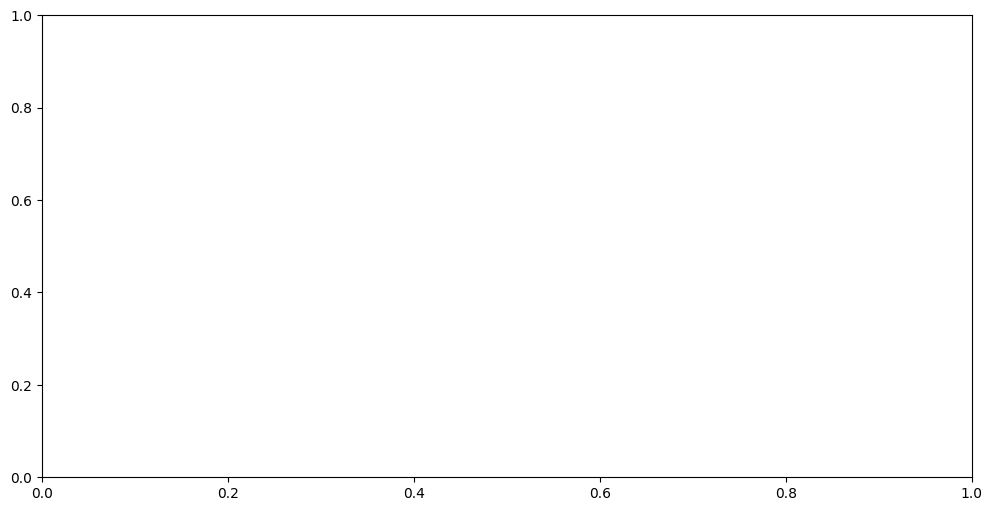

In [13]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCHS + 1), training_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss per Epoch, Training data not shuffled')
plt.show()


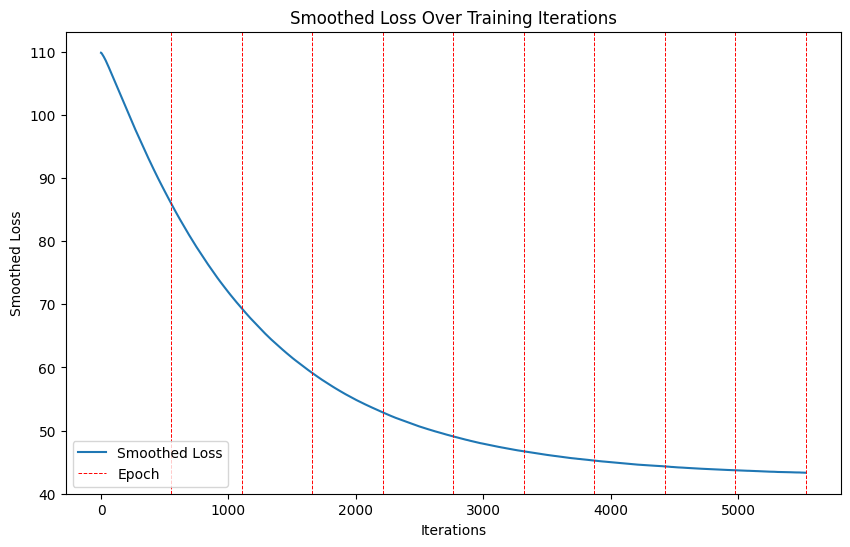

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(smoothed_losses, label='Smoothed Loss')
iterations_per_epoch = len(smoothed_losses) // EPOCHS

for epoch in range(1,EPOCHS+1):
    plt.axvline(x=epoch * iterations_per_epoch, color='r', linestyle='--', linewidth=0.7, label='Epoch' if epoch == 1 else "")

plt.xlabel('Iterations')
plt.ylabel('Smoothed Loss')
plt.title('Smoothed Loss Over Training Iterations')
plt.legend()
plt.show()

In [ ]:
generate_deterministic(model, 1000)

' the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the starting to the st

In [14]:
generate_nondeterministic(model, 200, temperature=1.5)

'alraxorne phemenghatly.\n"bevorg ithe torlarectionku\'t quack!n eham,dremelead ngorlf agll,zered bot Mreamerescrock.\nR gebonertsong suzat\'s moad.\nRom Hel lkscensted griDugnt inadcame, he, seinkleat itha'

In [15]:
generate_nondeterministic_nucleous(model, 200, 0.5, 0.9)

'ous and he rould his the call the stored had sherent of she was and here the cament and starred herrong and said Harry said Harry sand camered harrs there was a there and her was and he sagring harrs '